Loading images is working correctly

Resizing is working as expected both labels and images have been checked

I tried using two different learning rates for the encoder and decoder, and there was no significant difference, but as expected the smaller learning rate took longer to converge, but was more smooth. 


## Imports

In [1]:
# Add module files on path
import sys
sys.path.append('./modules')

# Importing
import cv2
import torch
import numpy as np
from model import Model
from scipy import ndimage
from torch.utils.data import DataLoader, random_split
from dataset import MyDecDataset, MySegDataset, MyDataLoader
from visualize import show_labeled_image,show_image_and_seg,show_image_and_probmap
from helpers import xml_to_csv,reverse_normalize,total_variation,to_device,get_predicted_centers,accuracy,to_device

torch.manual_seed(24)

In [2]:
# Choose device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


## Segmentation Dataset

In [3]:
# Create custom dataset
dataset_seg = MySegDataset('./Dataset/segmentation') # or define the w, and the h
print("Size of segmentation dataset ", len(dataset_seg))

Size of segmentation dataset  1192


In [4]:
# Split dataset
train_size = int(0.7 * len(dataset_seg))
test_size = int(0.15 * len(dataset_seg))
validation_size = len(dataset_seg) - (train_size + test_size)

train_seg, validation_seg, test_seg = random_split(dataset_seg, [train_size, validation_size, test_size])

In [5]:
print("Size of segmentation test set", len(test_seg))
print("Size of detection training set:", len(train_seg))
print("Size of detection validation set:", len(validation_seg))

Size of segmentation test set 178
Size of detection training set: 834
Size of detection validation set: 180


Target Shape:  torch.Size([1, 480, 640])
Image Shape:  torch.Size([3, 480, 640])


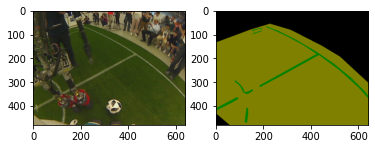

In [6]:
# Create dataloader for segmentation data
test_loader_seg = DataLoader(test_seg, batch_size=16, shuffle=True)
train_loader_seg = DataLoader(train_seg, batch_size=16, shuffle=True)
validation_loader_seg = DataLoader(validation_seg, batch_size=16, shuffle=True)

# Just as a sanity check display the train set
dataset_seg.set_resolution(480,640)
for image, target in train_loader_seg:
    print("Target Shape: ", target[0].shape)
    print("Image Shape: ", image[0].shape)
        
    show_image_and_seg(image[0],target[0])

    break

## Train

In [7]:
def train():
    # Model
    #model = Model(device,640,480)
    model = Model(device,160,128)
    model = to_device(model, device)

    # Training parameters
    epochs = 150
    learning_rate = 1e-3 # does this make a difference if we are using a scheduler ?
    optimizer_encoder = torch.optim.Adam(model.encoder.parameters(), learning_rate, weight_decay=0.001)
    optimizer_decoder = torch.optim.Adam(model.decoder.parameters(), learning_rate, weight_decay=0.001)
    scheduler_encoder = torch.optim.lr_scheduler.CyclicLR(optimizer_encoder,cycle_momentum=False,base_lr=1e-3,max_lr=1e-2,step_size_up=2000)
    scheduler_decoder = torch.optim.lr_scheduler.CyclicLR(optimizer_decoder,cycle_momentum=False,base_lr=1e-4,max_lr=1e-3,step_size_up=2000)

    # Current iteration
    iterations = 0

    # Resolution change flags
    set_resolution50 = False
    set_resolution100 = False
    set_resolution150 = False

    for epoch in range(epochs):
        # Segmentation and detection
        # cumulative losses
        cum_loss_seg = 0

        # Save model every 25 epochs
        #if (epoch % 25 == 0):
        #    torch.save(model.state_dict(), f"/home/user/taouil/NimbRoNet2/models/model_epoch_{epoch}.pt")

        if epoch < 50 and not set_resolution50:
            set_resolution50 = True

            # Freeze encoder layers
            model.freeze_encoder()

            # Set resolution to quarter of orignal size
            #dataset_dt.set_resolution(128,160)
            dataset_seg.set_resolution(128,160)
        elif 50 <= epoch < 100 and not set_resolution100:
            # Unfroze encoder layers
            model.unfreeze_encoder()

            # Set resolution to half original size
            #dataset_dt.set_resolution(256,320)
            dataset_seg.set_resolution(256,320)

            set_resolution100 = True
        elif 100 <= epoch < 150 and not set_resolution150:
            # Set resolution to original size
            dataset_seg.set_resolution(480,640)

            set_resolution150 = True

        # Segmentation training
        for batch_idx, batch in enumerate(train_loader_seg):
            batch = to_device(batch,device)

            # Clear gradients
            optimizer_encoder.zero_grad()
            optimizer_decoder.zero_grad()

            # Feed forward and get loss
            loss = model.training_step_segmentation(batch)

            # Compute gradient
            loss.backward()

            # Backprop
            optimizer_encoder.step()
            optimizer_decoder.step()
            scheduler_encoder.step()
            scheduler_decoder.step()

            cum_loss_seg += loss.item()/len(batch[0])

        # Validation for segmentation
        accuracy,iou = model.validation_segmentation(validation_loader_seg)
        print('SEGMENTATION -> Epoch: {}. Training Loss: {}. Validation Accuracy: {}\n'.format(epoch, cum_loss_seg, accuracy['Total']))


In [8]:
train()
#torch.save(model.state_dict(), f"/home/user/shoeb/NimbRoNet2/models/segmentation_150_0.41_97.pt")

SEGMENTATION -> Epoch: 0. Training Loss: 12.566610097885132. Validation Accuracy: 70.15234375

SEGMENTATION -> Epoch: 1. Training Loss: 7.921642102301121. Validation Accuracy: 84.40885416666667

SEGMENTATION -> Epoch: 2. Training Loss: 6.090397298336029. Validation Accuracy: 89.26432291666667

SEGMENTATION -> Epoch: 3. Training Loss: 4.487285055220127. Validation Accuracy: 90.91015625

SEGMENTATION -> Epoch: 4. Training Loss: 3.74277975410223. Validation Accuracy: 91.86197916666666

SEGMENTATION -> Epoch: 5. Training Loss: 3.2699905522167683. Validation Accuracy: 92.38541666666666

SEGMENTATION -> Epoch: 6. Training Loss: 2.7805418111383915. Validation Accuracy: 92.72699652777779

SEGMENTATION -> Epoch: 7. Training Loss: 2.389217358082533. Validation Accuracy: 92.93967013888889

SEGMENTATION -> Epoch: 8. Training Loss: 2.0911680329591036. Validation Accuracy: 93.36631944444444

SEGMENTATION -> Epoch: 9. Training Loss: 1.8546735625714064. Validation Accuracy: 93.77907986111111

SEGMENTA

In [ ]:
def train2():
    # Model
    #model = Model(device,640,480)
    model = Model(device,160,128)
    model = to_device(model, device)

    # Training parameters
    epochs = 150
    learning_rate = 1e-3 # does this make a difference if we are using a scheduler ?
    optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=0.001)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,cycle_momentum=False,base_lr=1e-3,max_lr=1e-2,step_size_up=2000)

    # Current iteration
    iterations = 0

    # Resolution change flags
    set_resolution50 = False
    set_resolution100 = False
    set_resolution150 = False

    for epoch in range(epochs):
        # Segmentation and detection
        # cumulative losses
        cum_loss_seg = 0

        # Save model every 25 epochs
        #if (epoch % 25 == 0):
        #    torch.save(model.state_dict(), f"/home/user/taouil/NimbRoNet2/models/model_epoch_{epoch}.pt")

        if epoch < 50 and not set_resolution50:
            set_resolution50 = True

            # Freeze encoder layers
            model.freeze_encoder()

            # Set resolution to quarter of orignal size
            #dataset_dt.set_resolution(128,160)
            dataset_seg.set_resolution(128,160)
        elif 50 <= epoch < 100 and not set_resolution100:
            # Unfroze encoder layers
            model.unfreeze_encoder()

            # Set resolution to half original size
            #dataset_dt.set_resolution(256,320)
            dataset_seg.set_resolution(256,320)

            set_resolution100 = True
        elif 100 <= epoch < 150 and not set_resolution150:
            # Set resolution to original size
            dataset_seg.set_resolution(480,640)

            set_resolution150 = True

        # Segmentation training
        for batch_idx, batch in enumerate(train_loader_seg):
            batch = to_device(batch,device)

            # Clear gradients
            optimizer.zero_grad()

            # Feed forward and get loss
            loss = model.training_step_segmentation(batch)

            # Compute gradient
            loss.backward()

            # Backprop
            optimizer.step()
            scheduler.step()

            cum_loss_seg += loss.item()/len(batch[0])

        # Validation for segmentation
        accuracy,iou = model.validation_segmentation(validation_loader_seg)
        print('SEGMENTATION -> Epoch: {}. Training Loss: {}. Validation Accuracy: {}\n'.format(epoch, cum_loss_seg, accuracy['Total']))
train2()

SEGMENTATION -> Epoch: 0. Training Loss: 6.380353651940823. Validation Accuracy: 91.89756944444444

SEGMENTATION -> Epoch: 1. Training Loss: 2.3701668716967106. Validation Accuracy: 93.5703125

SEGMENTATION -> Epoch: 2. Training Loss: 1.6735265273600817. Validation Accuracy: 94.54904513888889

SEGMENTATION -> Epoch: 3. Training Loss: 1.2825293689966202. Validation Accuracy: 95.03862847222221

SEGMENTATION -> Epoch: 4. Training Loss: 1.1341172009706497. Validation Accuracy: 95.21397569444444

SEGMENTATION -> Epoch: 5. Training Loss: 1.1082245204597712. Validation Accuracy: 95.5234375

SEGMENTATION -> Epoch: 6. Training Loss: 1.0431072358042002. Validation Accuracy: 95.55208333333334

SEGMENTATION -> Epoch: 7. Training Loss: 1.12452610488981. Validation Accuracy: 95.57161458333333

SEGMENTATION -> Epoch: 8. Training Loss: 1.1779829915612936. Validation Accuracy: 94.28602430555556

SEGMENTATION -> Epoch: 9. Training Loss: 1.0912650153040886. Validation Accuracy: 95.46397569444444

SEGMENT

Accuracy {'Total': 97.508046582397, 'Field': 98.64517349185483, 'Lines': 83.23054626189118, 'Background': 96.99946006156519}
IOU {'Field': 0.9615475126757063, 'Lines': 0.7374406611796045, 'Background': 0.9591070179508918, 'Total': 0.8860317306020674}


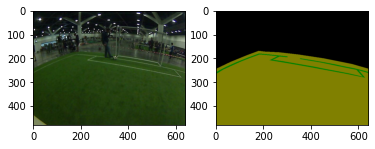

Model Result


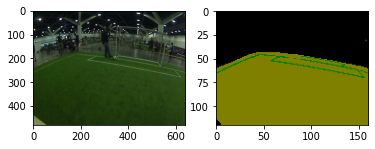

acc 98.1865234375
acc_field 98.87521288933934
acc_lines 84.73735566758822
acc_background 98.5109384662956
iou 0.905798726991249
iou_field 0.9714360506297928
iou_lines 0.7694750055379163
iou_background 0.9764851248060382


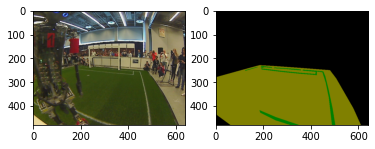

Model Result


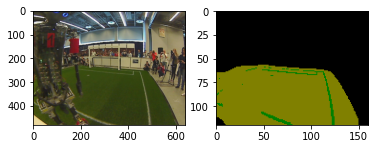

acc 97.36002604166667
acc_field 98.78631214821131
acc_lines 77.78744129413812
acc_background 97.00450185237185
iou 0.8669082684386544
iou_field 0.9577911375516034
iou_lines 0.6781408749715672
iou_background 0.9647927927927928


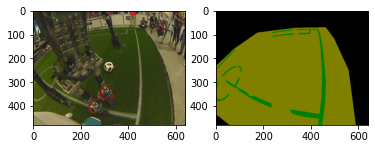

Model Result


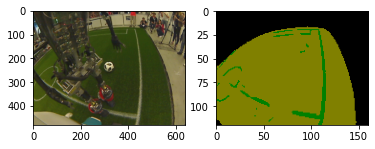

acc 97.49348958333334
acc_field 98.98174881418849
acc_lines 84.71963408436388
acc_background 96.13443224165468
iou 0.8943163525979433
iou_field 0.9622198944482591
iou_lines 0.7680258005067957
iou_background 0.9527033628387752


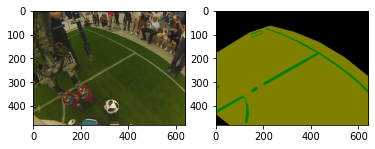

Model Result


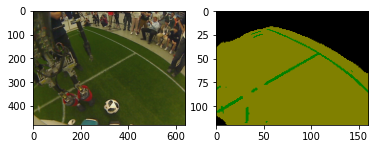

acc 97.146484375
acc_field 98.58310365743351
acc_lines 84.18547081786156
acc_background 95.9154398580243
iou 0.8721734692339154
iou_field 0.9553132250580046
iou_lines 0.7090048913479272
iou_background 0.9522022912958145


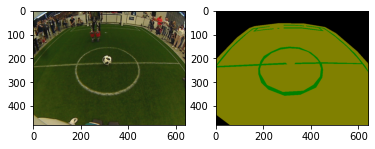

Model Result


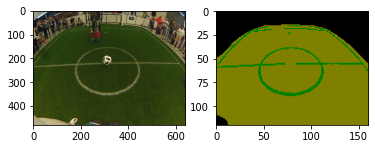

acc 97.97265625
acc_field 97.93496493017454
acc_lines 86.72440944881889
acc_background 99.69187579170804
iou 0.9026869878278988
iou_field 0.9702787741790265
iou_lines 0.770694842908124
iou_background 0.967087346396546


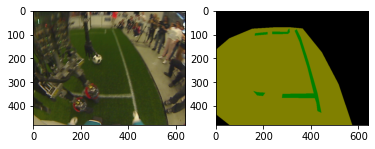

Model Result


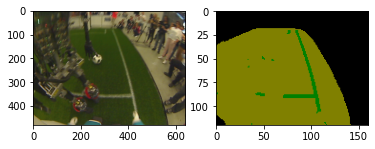

acc 98.05729166666667
acc_field 98.64843254285553
acc_lines 87.04830383480827
acc_background 98.1044457235398
iou 0.8985320486283995
iou_field 0.9698145358832747
iou_lines 0.7538117665841781
iou_background 0.971969843417746


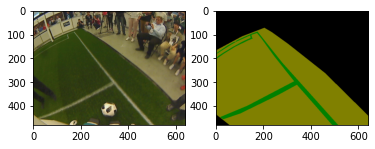

Model Result


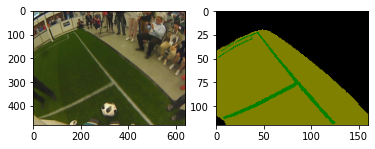

acc 96.81575520833333
acc_field 98.59293609452419
acc_lines 76.25512295081968
acc_background 95.92527959168355
iou 0.8620554406927786
iou_field 0.9505450759431651
iou_lines 0.6898123117324477
iou_background 0.9458089344027234


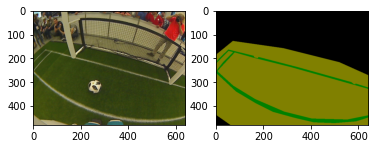

Model Result


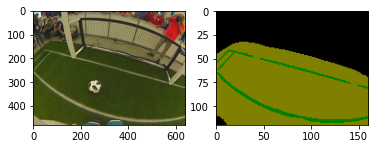

acc 98.11979166666667
acc_field 98.44727647688934
acc_lines 83.79761227970438
acc_background 99.28608228453669
iou 0.8982326121945682
iou_field 0.9714985724588285
iou_lines 0.7468152866242038
iou_background 0.9763839775006721


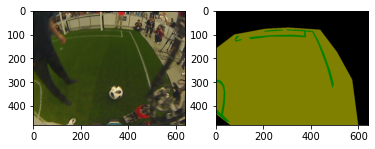

Model Result


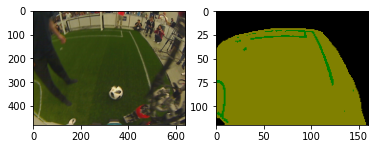

acc 97.98828125
acc_field 98.84772212694745
acc_lines 84.19744906410469
acc_background 97.99445733815134
iou 0.9015755865979425
iou_field 0.9686976389946687
iou_lines 0.7659734779987944
iou_background 0.9700556428003645


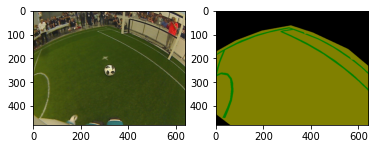

Model Result


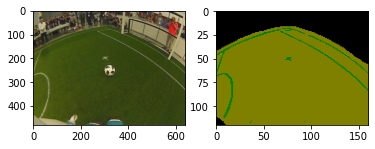

acc 96.2744140625
acc_field 98.85750804453363
acc_lines 84.18508905396939
acc_background 93.50588635301118
iou 0.8682207956866664
iou_field 0.9395692806069712
iou_lines 0.7339836129535701
iou_background 0.9311094934994583


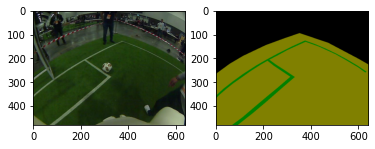

Model Result


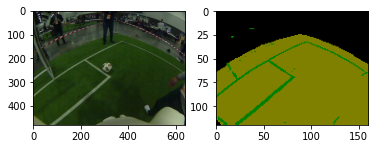

acc 98.0517578125
acc_field 98.71530668182649
acc_lines 85.13918629550321
acc_background 98.25505263264746
iou 0.8970581721334113
iou_field 0.9704447017025608
iou_lines 0.7478182365332531
iou_background 0.9729115781644202


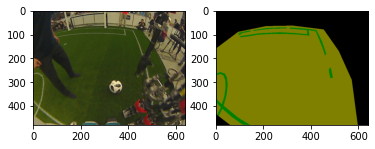

Model Result


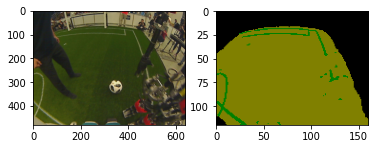

acc 97.27083333333333
acc_field 97.98601398601399
acc_lines 90.51878354203936
acc_background 96.42653177775965
iou 0.8776457713399445
iou_field 0.9590503754693367
iou_lines 0.7275341480948958
iou_background 0.946352790455601


In [9]:
model = Model(device,640,480)
model = to_device(model, device)

model.load_state_dict(torch.load("/home/user/shoeb/NimbRoNet2/models/segmentation_150_0.38_97.pt"), strict=False)
accuracy,iou = model.validation_segmentation(test_loader_seg)
print('Accuracy',accuracy)
print('IOU',iou)
correct = 0
total = 0
correct_field = 0
total_field = 0
correct_lines = 0
total_lines = 0
correct_background = 0
total_background = 0
for image, target in test_loader_seg:    
    show_image_and_seg(image[0],target[0])
    image_gpu = to_device(image,device)
    output = model(image_gpu,head="segmentation")
    
    
    softmax = torch.nn.LogSoftmax(dim=1) # wait for hafez reply if it is needed or not
    softmax_output = softmax(output)
            
    # Get predictions from the maximum value
    _, predicted = torch.max(softmax_output, 1)
    
    predicted = predicted.detach()
    print('Model Result')
    show_image_and_seg(image[0],predicted.cpu())
    
    downsampled_target = torch.nn.functional.interpolate(target,scale_factor=0.25,
                                                                 mode="nearest",
                                                                 recompute_scale_factor=False)
    downsampled_target = torch.squeeze(downsampled_target,dim=1) #(batch_size,1,H,W) -> (batch_size,H,W)
    downsampled_target = downsampled_target.type(torch.LongTensor) # convert the target from float to int
    
     # Total correct predictions
    c_base = predicted.cpu() == downsampled_target.cpu()
    correct = (predicted.cpu() == downsampled_target.cpu()).sum().item()
    field_mask = downsampled_target.cpu()==1
    correct_field = (np.logical_and(c_base,field_mask)).sum().item()
    line_mask = downsampled_target.cpu()==2
    correct_lines =(np.logical_and(c_base,line_mask)).sum().item()
    background_mask = downsampled_target.cpu()==0
    correct_background =(np.logical_and(c_base,background_mask)).sum().item()

    # Total number of labels
    total = (downsampled_target.size(0)*downsampled_target.size(1)*downsampled_target.size(2))
    total_field = field_mask.sum().item()
    total_lines =line_mask.sum().item()
    total_background =background_mask.sum().item()
    
    # IOU true positive / (true positive + false positive + false negative)
    tp_field = (np.logical_and(c_base,field_mask)).sum().item()
    pred_field = predicted.cpu() == 1
    fp_field = (np.logical_and(pred_field ,np.logical_not(field_mask))).sum().item()
    fn_field = (np.logical_and(np.logical_not(np.logical_and(c_base,field_mask)),field_mask)).sum().item()
    iou_field = tp_field / (tp_field+fp_field+fn_field)
    tn_field = (np.logical_and(np.logical_not(pred_field),np.logical_not(field_mask))).sum().item()# Just as a sanity check
    
    
    tp_lines = (np.logical_and(c_base,line_mask)).sum().item()
    pred_lines = predicted.cpu() == 2
    fp_lines = (np.logical_and(pred_lines ,np.logical_not(line_mask))).sum().item()
    fn_lines = (np.logical_and(np.logical_not(np.logical_and(c_base,line_mask)),line_mask)).sum().item()
    iou_lines = tp_lines / (tp_lines+fp_lines+fn_lines)
    tn_lines = (np.logical_and(np.logical_not(pred_lines),np.logical_not(line_mask))).sum().item()# Just as a sanity check

    
    tp_background = (np.logical_and(c_base,background_mask)).sum().item()
    pred_background = predicted.cpu() == 0
    fp_background = (np.logical_and(pred_background ,np.logical_not(background_mask))).sum().item()
    fn_background = (np.logical_and(np.logical_not(np.logical_and(c_base,background_mask)),background_mask)).sum().item()
    iou_background = tp_background / (tp_background+fp_background+fn_background)
    tn_background = (np.logical_and(np.logical_not(pred_background),np.logical_not(background_mask))).sum().item()# Just as a sanity check

    
    
    
    print('acc',100 * (correct / total))
    print('acc_field',100 * (correct_field / total_field))
    print('acc_lines',100 * (correct_lines / total_lines))
    print('acc_background',100 * (correct_background / total_background))
    
    print('iou',(iou_lines+iou_field+iou_background)/3)
    print('iou_field',iou_field)
    print('iou_lines',iou_lines)
    print('iou_background',iou_background)
    
    